# Classfication with Deep Neural Networks

## Load MNIST Dataset

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets, transforms

In [3]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [4]:
# 데이터 예제를 살펴보자.
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)
    
    plt.imshow(img, cmap='gray')
    plt.show()

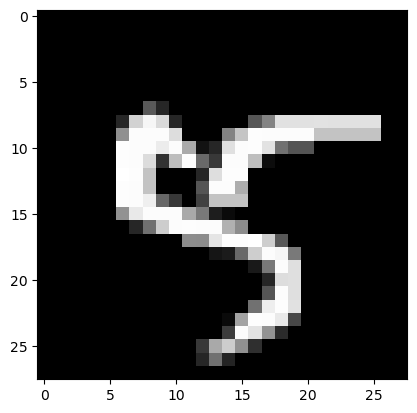

This data's label is 5.


In [5]:
n = 1402
plot(train.data[n])
print("This data's label is {}.".format(train.targets[n].numpy()))

In [6]:
# min/max scaling

x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1) # 텐서의 모양을 조절하는 메서드. -1은 차원을 자동으로 조정하라는 의미
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [7]:
input_size = x.size(-1) # 784
output_size = int(max(y)) + 1
print('input_size: {}, output_size: {}'.format(input_size, output_size))

input_size: 784, output_size: 10


In [8]:
# Train / Valid ratio

ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = x.size(0) - train_cnt
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

cnts

[48000, 12000]

In [9]:
# shuffle and split to data
indices = torch.randperm(x.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

# += 이기 때문에 x에 test set 리스트를 추가한 것
# .view(size, -1)은 flatten작업이다. 한 줄의 벡터로 데이터를 변환한다.
x += [(test.data.float() / 255.).view(test_cnt, -1)] 
y += [test.targets]
# 근데 왜 test를 굳이 x와 y에 추가할까?

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


## Build Model & Optimizer

In [20]:
# 각 클래스에 대한 확률값을 반환하는 모델
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1) # what is mean of dim? # |y_hat| = (batch_size, 10) 이므로 10에 대해서 LogSoftmax를 취하라는 의미
)

model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [21]:
#criterion function == cost function == loss function
crit = nn.NLLLoss()

In [22]:
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available

In [23]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Device attach to GPU")

Device attach to GPU


In [24]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

## Train 

In [25]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [26]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [27]:
y[0].size()

torch.Size([48000])

In [28]:
# Let's Train!

train_history, valid_history = [], []

for i in range(n_epochs):
    # shuffle data
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    # split data
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze()) # y_i.squeeze() # 차원이 1인 axis를 제거한다. #근데 |y_i| = (batch_size) 아닌가? 
    
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss) # This is very important to prevent memory leak.
        
    train_loss = train_loss / len(x_)
    
    # Validation sector
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
            # y_hat += [y_hat_i] # 나중에 torch.cat(y_hat, dim=0)으로 결과 벡터를 만들 때 사용하는 것 같지만 여기서는 사용하지 않으므로 주석처리
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    
    if (i + 1) % print_interval == 0:
        print("Epoch {}: train loss={:.4f} / valid loss={:.4f} / lowest loss={:.4f}".format(i+1, train_loss, valid_loss, lowest_loss))
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
        print("  >> Catch the best model- Epoch: {} / Loss: {:.4f}".format(lowest_epoch+1, lowest_loss))
        
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print("There is no improvement during last {} epochs.".format(early_stop))
            break

print("The best validation loss from epoch {}: {:.4f}".format(lowest_epoch +1, lowest_loss))
model.load_state_dict(best_model)

  >> Catch the best model- Epoch: 0 / Loss: 0.2328
  >> Catch the best model- Epoch: 1 / Loss: 0.1418
  >> Catch the best model- Epoch: 2 / Loss: 0.1209
  >> Catch the best model- Epoch: 4 / Loss: 0.1045
  >> Catch the best model- Epoch: 6 / Loss: 0.0969
Epoch 10: train loss=0.0264 / valid loss=0.1106 / lowest loss=0.0969
Epoch 20: train loss=0.0105 / valid loss=0.1243 / lowest loss=0.0969
Epoch 30: train loss=0.0070 / valid loss=0.1290 / lowest loss=0.0969
Epoch 40: train loss=0.0068 / valid loss=0.1327 / lowest loss=0.0969
Epoch 50: train loss=0.0079 / valid loss=0.1314 / lowest loss=0.0969
Epoch 60: train loss=0.0025 / valid loss=0.1518 / lowest loss=0.0969
Epoch 70: train loss=0.0024 / valid loss=0.1504 / lowest loss=0.0969
Epoch 80: train loss=0.0017 / valid loss=0.1576 / lowest loss=0.0969
Epoch 90: train loss=0.0027 / valid loss=0.1516 / lowest loss=0.0969
Epoch 100: train loss=0.0000 / valid loss=0.1600 / lowest loss=0.0969
There is no improvement during last 100 epochs.
The be

<All keys matched successfully>

## Loss History

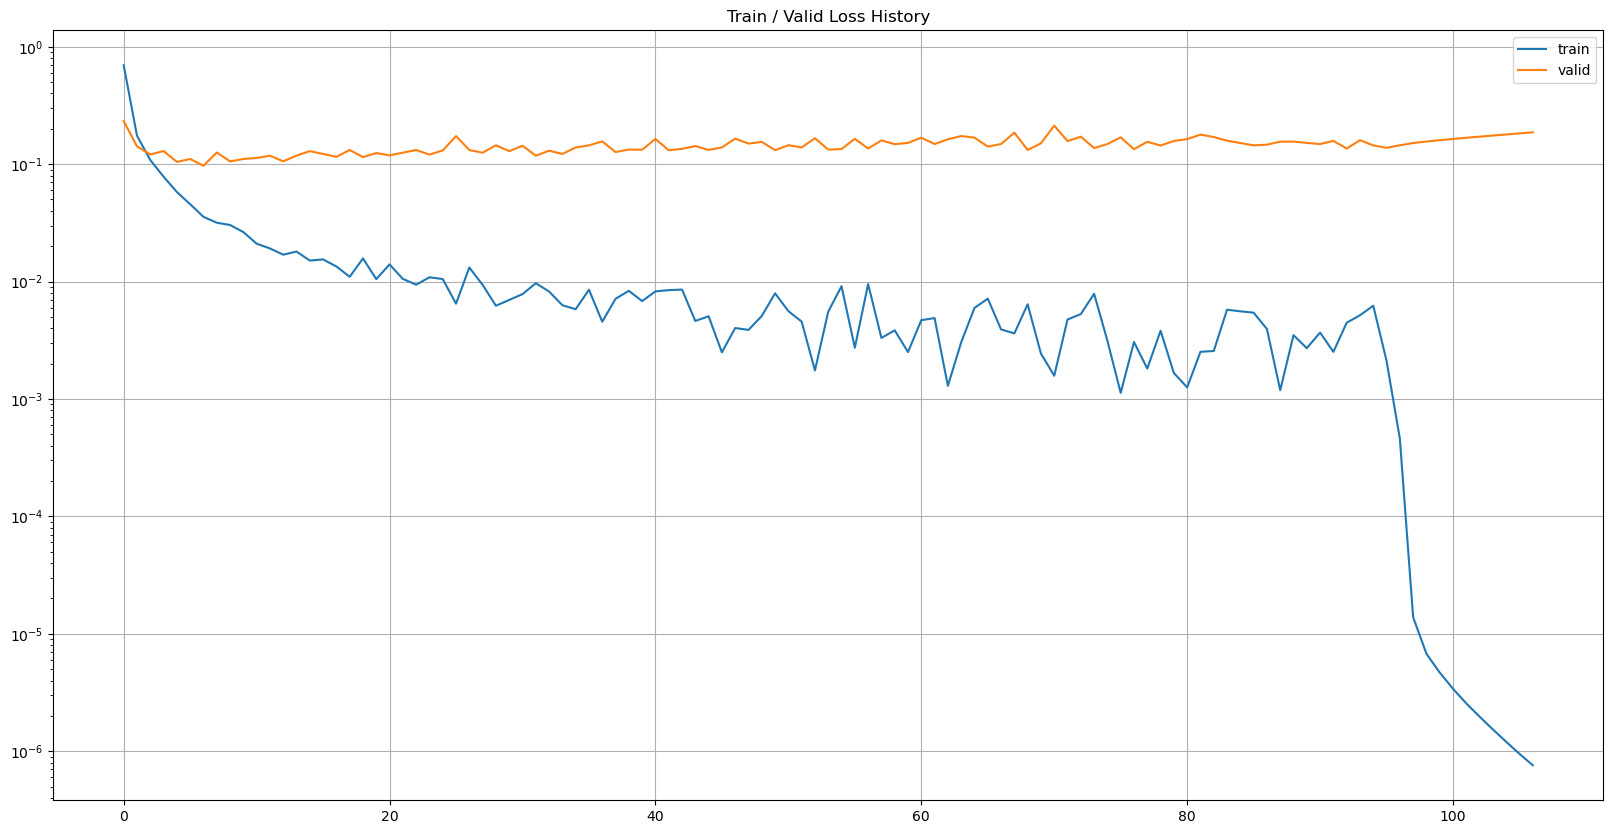

In [29]:
plot_from = 0
plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='train')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='valid')

plt.yscale('log')
plt.legend()
plt.show()

# Let's see the result!

In [30]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i)
        
        test_loss += float(loss)
        
        y_hat += [y_hat_i]
        
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)
print("Test loss: {:.4f}".format(test_loss))

Test loss: 0.0832


In [31]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print("Accuracy: {:.4f}".format(correct_cnt/total_cnt))

Accuracy: 0.9773


In [32]:
# confusion matrix
import pandas as pd
from sklearn.metrics import confusion_matrix

In [39]:
# device -> cpu
true = y[-1].cpu().numpy()
pred = torch.argmax(y_hat, dim=-1).cpu().numpy()
pd.DataFrame(confusion_matrix(true, pred),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,974,0,1,0,0,0,1,0,3,1
true_1,0,1127,1,1,0,0,2,0,4,0
true_2,9,4,996,6,2,0,1,6,7,1
true_3,0,0,6,989,1,4,0,6,2,2
true_4,1,0,5,0,967,0,1,2,0,6
true_5,5,0,0,5,2,870,1,1,4,4
true_6,5,3,2,0,12,9,926,0,1,0
true_7,2,4,5,0,1,0,0,1007,3,6
true_8,2,0,1,5,3,6,0,3,950,4
true_9,4,3,0,7,14,2,0,11,1,967


# 틀린 데이터의 모양 좀 살펴보자


In [ ]:
incorrect_data = correct_cnt = (y[-1].squeeze() != )

In [45]:
true=y[-1].squeeze().tolist()
pred=torch.argmax(y_hat, dim=-1).tolist()

In [49]:
incorrect_index = [i for i in range(len(true)) if true[i]!=pred[i]]
len(incorrect_index)

227

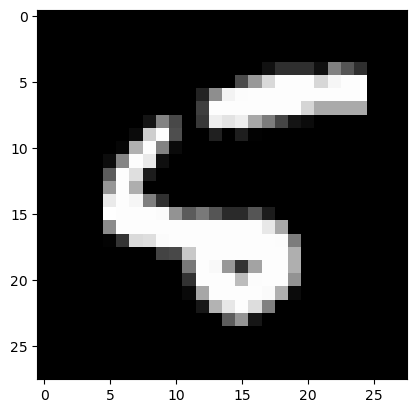

Predicted to 4
This data's label is 5.


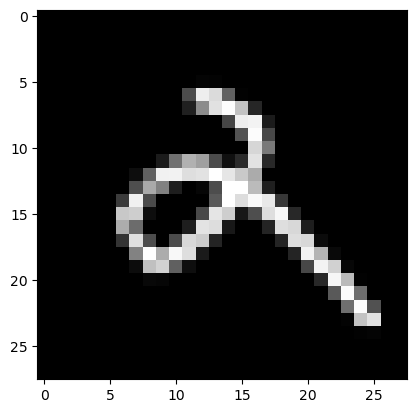

Predicted to 9
This data's label is 2.


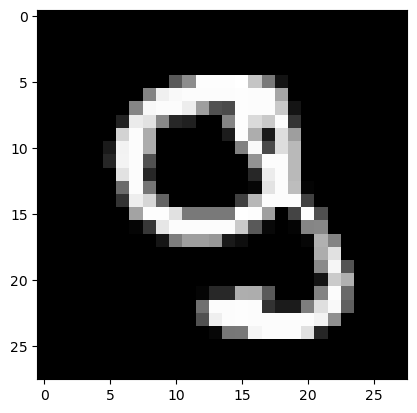

Predicted to 8
This data's label is 9.


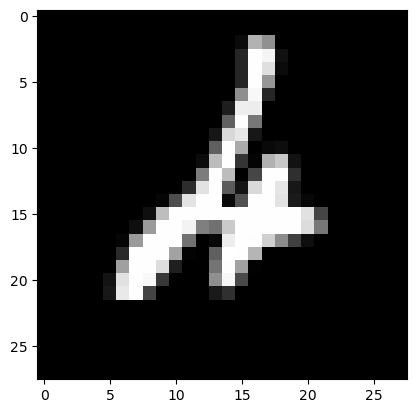

Predicted to 2
This data's label is 4.


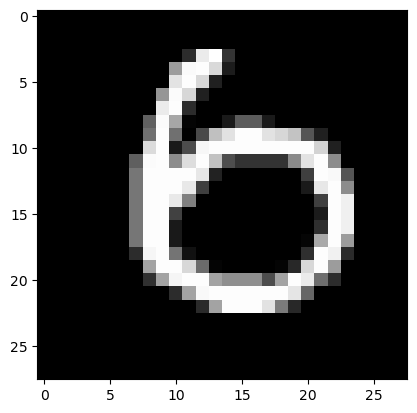

Predicted to 0
This data's label is 6.


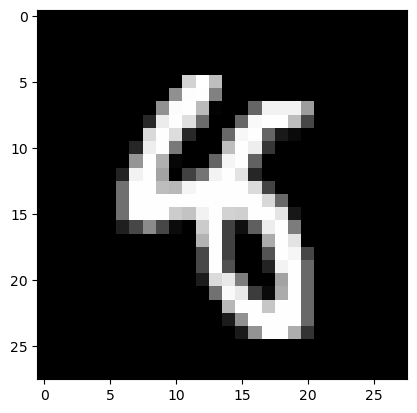

Predicted to 4
This data's label is 8.


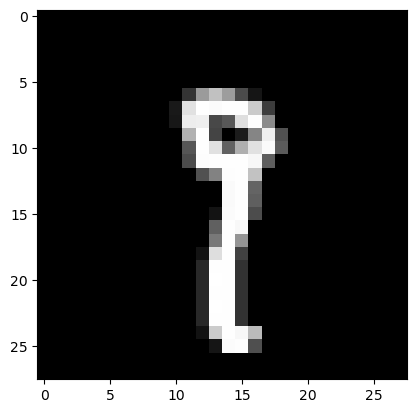

Predicted to 7
This data's label is 9.


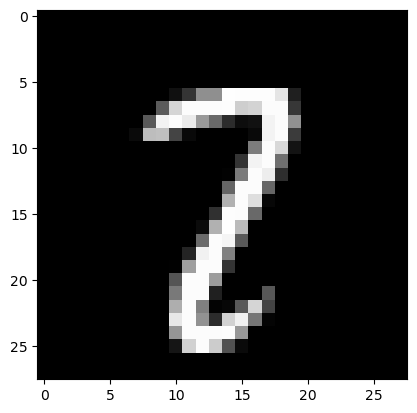

Predicted to 7
This data's label is 2.


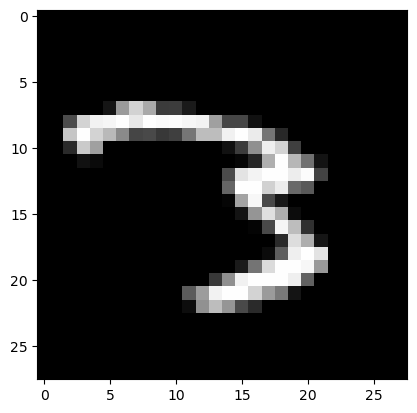

Predicted to 7
This data's label is 3.


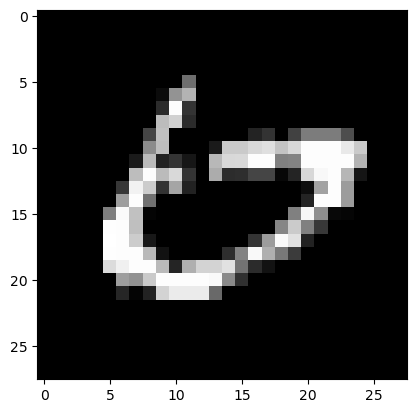

Predicted to 0
This data's label is 6.


In [54]:
for i in range(10):
    idx = incorrect_index[i]
    plot(test.data[idx])
    print("Predicted to {}".format(pred[idx]))
    print("This data's label is {}.".format(true[idx]))